# **Finding Lane Lines on the Road** 
Built by Galen Ballew in December 2016 through the Udacity Self Driving Car Engineer Nanodegree*
***
In this project, I built a computer vision pipeline for detecting lane lines and creating averaged and extrapolated boundary lines.
The pipeline is as follows: 

1) Convert frame to grayscale  
2) Create masks for yellow and white pixels  
3) Apply a Gaussian smoothing  
4) Apply a Canny edge detection  
5) Create an additional mask to focus on the "region of interest" in front of the vehicle  
6) Convert the points(i.e. pixels) in XY space to a line in Hough space  
7) Where the lines in Hough space intersect (i.e. a point) a line exists in XY space  
8) Using the extrema of the lines generated, create two averaged line  s
9) Create two averaged lines across frames for a smooth video playback  
10) Draw the lines to each frame
***


<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Raw lines after conversion from Hough space </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Averaged lines for smooth playback</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

## 0. 테스트 이미지 보기

### 0-1. matplotlib로 보기

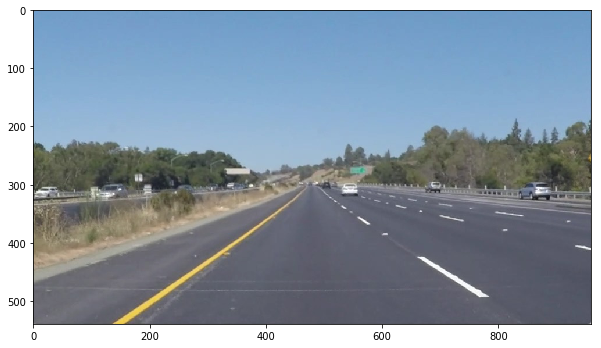

In [3]:
image_paths = os.listdir("test_images/")
image_path = "test_images/" + image_paths[4]
image = mpimg.imread(image_path)

plt.imshow(image)

### 0-2. highgui(OpenCV GUI)로 보기

In [4]:
'''
bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imshow("image", bgr_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

'\nbgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)\ncv2.imshow("image", bgr_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

### 0-3. IPython에서 보기

In [5]:
HTML('<img src="{0}"  width="960" height="540">'.format(image_path))

## 1. 이미지를 grayscale로 변경

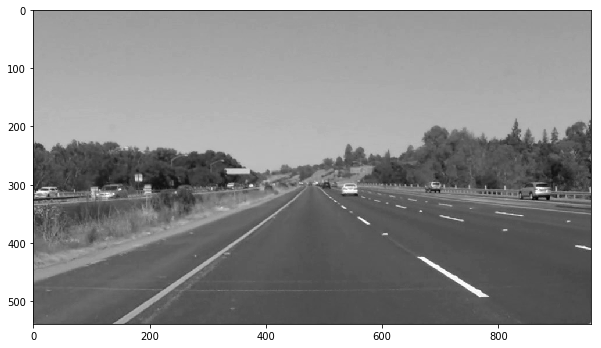

In [6]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image)

## 2. HSV에서 차선 색추출

### 2-1. RGB to HSV

In [7]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

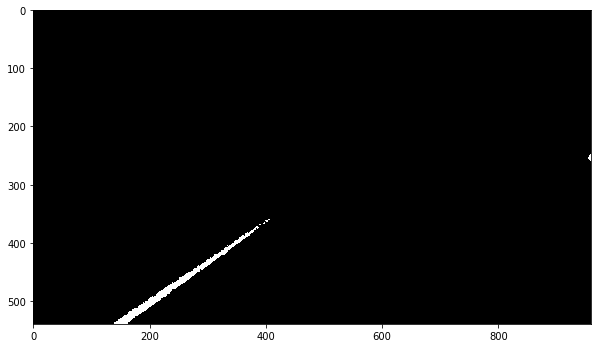

In [8]:
lower_yellow = np.array([20, 100, 100], dtype = "uint8")
upper_yellow = np.array([30, 255, 255], dtype="uint8")

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)

plt.imshow(mask_yellow)

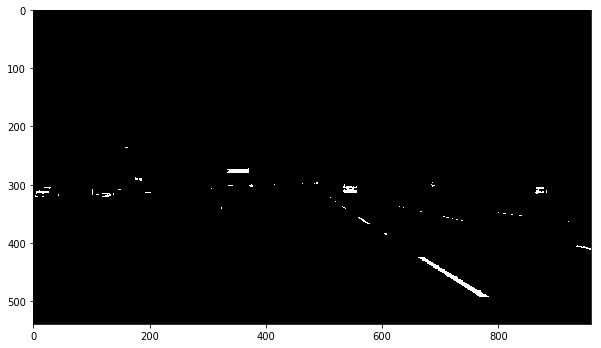

In [9]:
mask_white = cv2.inRange(gray_image, 200, 255)

plt.imshow(mask_white)

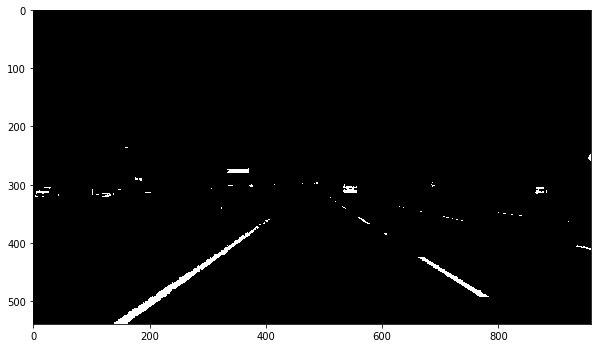

In [10]:
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)

plt.imshow(mask_yw)

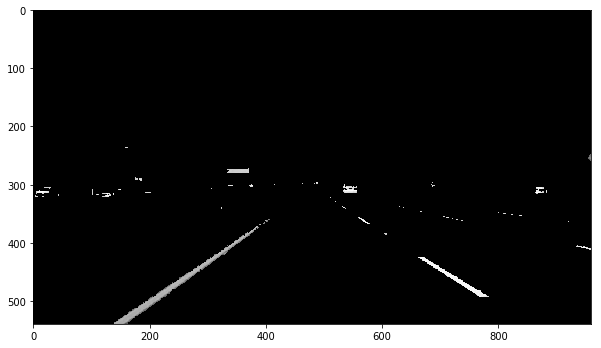

In [11]:
mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)

plt.imshow(mask_yw_image)

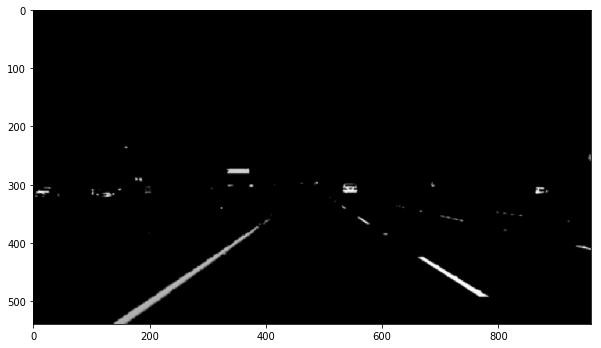

In [12]:
kernel_size = 5
gauss_gray = cv2.GaussianBlur(mask_yw_image, (kernel_size, kernel_size), 0)

plt.imshow(gauss_gray)

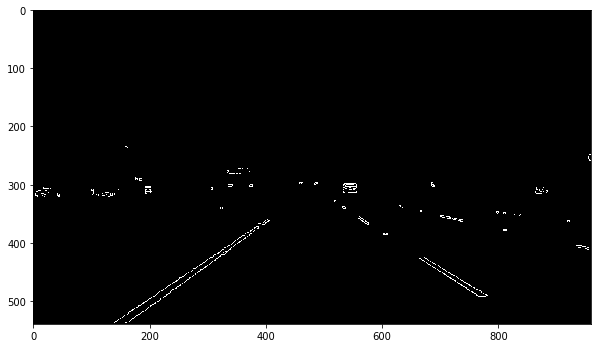

In [13]:
low_threshold = 50
high_threshold = 150
canny_edges = cv2.Canny(gauss_gray, low_threshold, high_threshold)

plt.imshow(canny_edges)

In [14]:
np.set_printoptions(linewidth=160)
print(canny_edges[500:520, 180:200])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255 255 255   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 255 255   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255]
 [  

In [15]:
imshape = image.shape

print(imshape)

(540, 960, 3)


lower_left :  [106.66666666666667, 540]
lower_right :  [853.3333333333334, 540]
top_left :  [360.0, 324.0]
top_right :  [600.0, 324.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


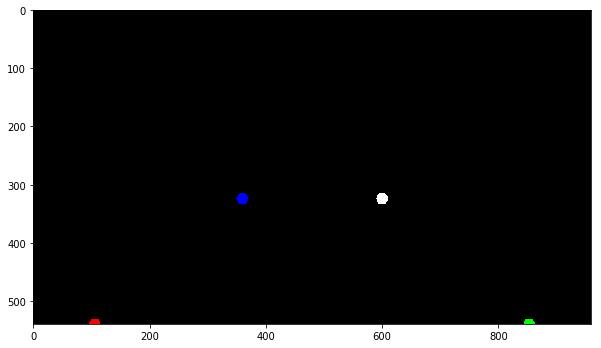

In [16]:
lower_left = [imshape[1]/9,imshape[0]]
lower_right = [imshape[1]-imshape[1]/9,imshape[0]]
top_left = [imshape[1]/2-imshape[1]/8,imshape[0]/2+imshape[0]/10]
top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]

print('lower_left : ',lower_left)
print('lower_right : ',lower_right)
print('top_left : ',top_left)
print('top_right : ',top_right)

test_image = np.zeros(imshape)
radius = 10
cv2.circle(test_image, (int(lower_left[0]), int(lower_left[1])), radius, (255, 0, 0), -1)
cv2.circle(test_image, (int(lower_right[0]), int(lower_right[1])), radius, (0, 255, 0), -1)
cv2.circle(test_image, (int(top_left[0]), int(top_left[1])), radius, (0, 0, 255), -1)
cv2.circle(test_image, (int(top_right[0]), int(top_right[1])), radius, (255, 255, 255), -1)
plt.imshow(test_image)

(255, 255, 255)


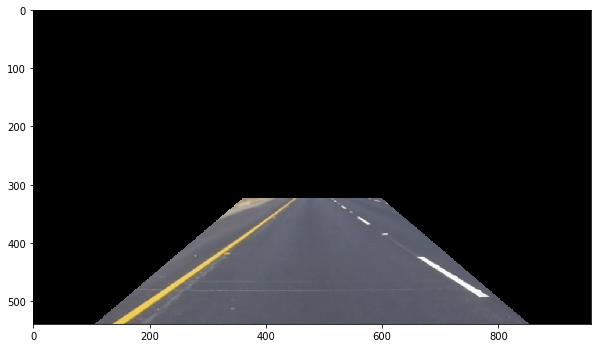

In [17]:
def region_of_interest(img, vertices):    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count # (255, 255, 255)
        print(ignore_mask_color)
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)] # 좌표 최대값이 960px까지여서 int32로 지정
roi_image = region_of_interest(image, vertices)

plt.imshow(roi_image, cmap='gray')

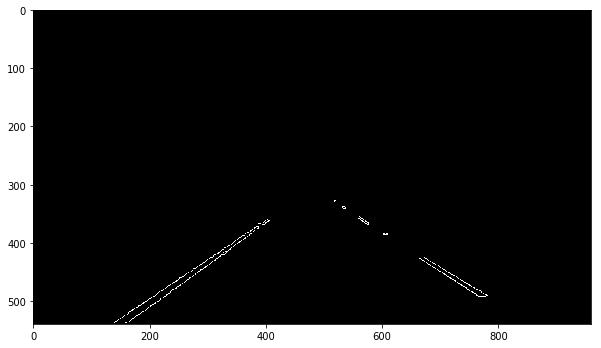

In [18]:
vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
roi_image = region_of_interest(canny_edges, vertices)

plt.imshow(roi_image, cmap='gray')

In [19]:
#rho and theta are the distance and angular resolution of the grid in Hough space
#same values as quiz
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
min_line_len = 100
max_line_gap = 180
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

lines = cv2.HoughLinesP(roi_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
print(lines)

[[[139 538 403 360]]

 [[162 538 406 361]]

 [[518 328 782 493]]

 [[531 339 766 492]]

 [[163 536 407 359]]

 [[218 499 397 365]]

 [[518 327 772 492]]

 [[259 469 405 359]]

 [[158 538 333 406]]]


[139 538 403 360]


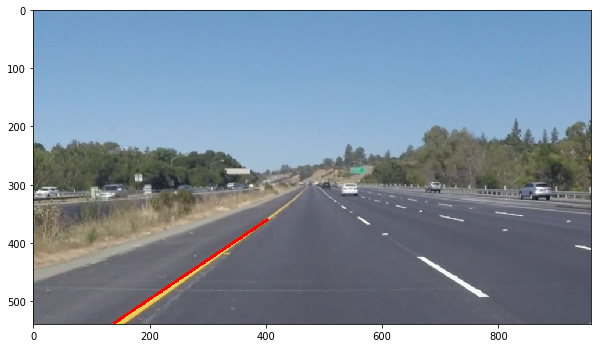

In [20]:
print(lines[0][0])
x1, y1, x2, y2 = lines[0][0]

copy_image = image.copy()
cv2.line(copy_image,(x1,y1),(x2,y2),(255,0,0),3)
plt.imshow(copy_image)

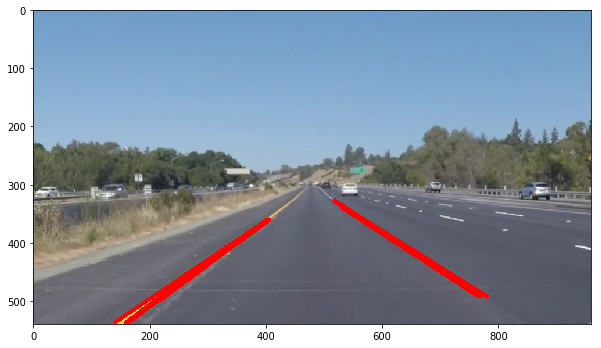

In [21]:
def draw_lines(image, lines):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image,(x1,y1),(x2,y2),(255,0,0),6)

copy_image = image.copy()
draw_lines(copy_image, lines)
plt.imshow(copy_image)

In [22]:
# 기울기 구하는 함수
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

det_slope = 0.4
for line in lines:
    # 기울기가 -0.4보다 작은 라인만 l_lane배열에 담는다.
    for x1,y1,x2,y2 in line:
        slope = get_slope(x1,y1,x2,y2)        
        if math.inf > slope > det_slope:
            print('right : ', slope)
        elif -math.inf < slope < -det_slope:
            print('left : ', slope)

left :  -0.6742424242424242
left :  -0.7254098360655737
right :  0.625
right :  0.6510638297872341
left :  -0.7254098360655737
left :  -0.7486033519553073
right :  0.6496062992125984
left :  -0.7534246575342466
left :  -0.7542857142857143


## 차선 다듬기

In [23]:
# 차선 다듬는 함수
def trim_lines(lines, img_height):
    
    if lines is None:
        return
        
    y_global_min = img_height
    y_max = img_height
    l_slope, r_slope = [],[]
    l_lane,r_lane = [],[]
    det_slope = 0.4
    for line in lines:
        # 기울기가 -0.4보다 작은 라인만 l_lane배열에 담는다.
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            # 기울기가 0.4보다 큰 라인만 오른쪽(r_lane) 배열에 담는다.
            if math.inf > slope > det_slope:
                r_slope.append(slope)
                r_lane.append(line)
            # 기울기가 -0.4보다 작은 라인만 왼쪽(l_lane) 배열에 담는다.
            elif -math.inf < slope < -det_slope:
                l_slope.append(slope)
                l_lane.append(line)

            # 라인들의 top 위치를 선별함
            y_global_min = min(y1,y2,y_global_min)
            y_max = max(y1,y2,y_max)
    
    if((len(l_lane) == 0) or (len(r_lane) == 0)):
        print ('no lane detected')
        return
    
    # 왼쪽과 오른쪽 라인들을 각각 평균해서 하나로 만든다.
    l_slope_mean = np.mean(l_slope,axis =0)
    r_slope_mean = np.mean(r_slope,axis =0)
    l_mean = np.mean(np.array(l_lane),axis=0)
    r_mean = np.mean(np.array(r_lane),axis=0) 
    
    if ((r_slope_mean == 0) or (l_slope_mean == 0 )):
        print('dividing by zero')
        return
    
    # 평균한 라인에서 y절편(bias)를 구한다.
    #4, y=mx+b -> b = y -mx
    l_b = l_mean[0][1] - (l_slope_mean * l_mean[0][0])
    r_b = r_mean[0][1] - (r_slope_mean * r_mean[0][0])    
       
    # x = (y - b) / m
    l_x1 = int((y_global_min - l_b)/l_slope_mean)                
    l_x2 = int((y_max - l_b)/l_slope_mean)   
    r_x1 = int((y_global_min - r_b)/r_slope_mean)
    r_x2 = int((y_max - r_b)/r_slope_mean)  
        
    if l_x1 > r_x1:
        # 선이 교차하면 교점으로 소실점으로 만들어줌
        l_x1 = int((l_x1+r_x1)/2)
        r_x1 = l_x1
        # y = mx + b    
        l_y1 = int((l_slope_mean * l_x1 ) + l_b)
        r_y1 = int((r_slope_mean * r_x1 ) + r_b)
        l_y2 = int((l_slope_mean * l_x2 ) + l_b)
        r_y2 = int((r_slope_mean * r_x2 ) + r_b)
    else:
        l_y1 = y_global_min
        l_y2 = y_max
        r_y1 = y_global_min
        r_y2 = y_max    
    return [[[l_x1,l_y1,l_x2,l_y2],[r_x1,r_y1,r_x2,r_y2]]]
    

In [24]:
lines = trim_lines(lines, image.shape[1])

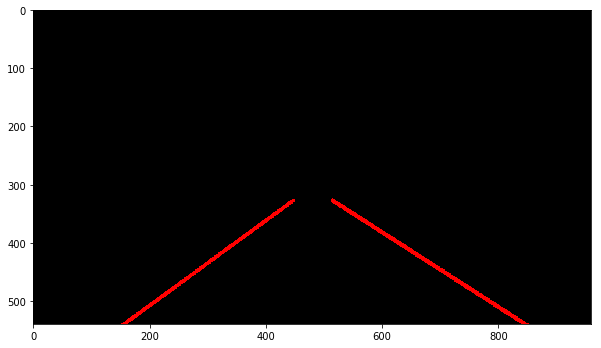

In [25]:
copy_image = np.zeros(image.shape, dtype=np.uint8)

if lines != None:
    draw_lines(copy_image, lines)
    plt.imshow(copy_image)

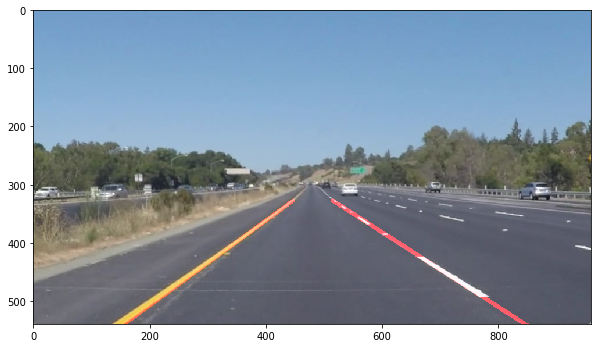

In [26]:
α=0.9
β=1.
λ=0.
result_image = cv2.addWeighted(copy_image, α, image, β, λ)
plt.imshow(result_image)

In [27]:
def process_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 100, 100], dtype = "uint8")
    upper_yellow = np.array([30, 255, 255], dtype="uint8")
    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)
    
    kernel_size = 5
    gauss_gray = cv2.GaussianBlur(mask_yw_image, (kernel_size, kernel_size), 0)
    
    low_threshold = 50
    high_threshold = 150
    canny_edges = cv2.Canny(gauss_gray, low_threshold, high_threshold)
    
    lower_left = [imshape[1]/9,imshape[0]]
    lower_right = [imshape[1]-imshape[1]/9,imshape[0]]
    top_left = [imshape[1]/2-imshape[1]/8,imshape[0]/2+imshape[0]/10]
    top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]
    
    vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
    roi_image = region_of_interest(canny_edges, vertices)

    rho = 4
    theta = np.pi/180
    threshold = 30
    min_line_len = 100
    max_line_gap = 180
    lines = cv2.HoughLinesP(roi_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
    
    lines = trim_lines(lines, image.shape[1])      

    if lines == None:
        return image
    
    line_image = np.zeros(image.shape, dtype=np.uint8)
    draw_lines(line_image, lines)
    
    α=0.9
    β=1.
    λ=0.
    result_image = cv2.addWeighted(line_image, α, image, β, λ)
        
    return result_image    

## Test on Images

Run on single still frames

In [28]:
for source_img in os.listdir("test_images/"):
    first_frame = 1
    image = mpimg.imread("test_images/"+source_img)
    processed = process_image(image)
    mpimg.imsave("out_images/annotated_"+source_img, processed)

## Test on Videos

Apply the still frame processing to video feeds

In [29]:
first_frame = 1
white_output = 'out_videos/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video out_videos/white.mp4.
Moviepy - Writing video out_videos/white.mp4



Moviepy - Done !
Moviepy - video ready out_videos/white.mp4
Wall time: 5.2 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [31]:
first_frame = 1
yellow_output = 'out_videos/yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video out_videos/yellow.mp4.
Moviepy - Writing video out_videos/yellow.mp4



Moviepy - Done !
Moviepy - video ready out_videos/yellow.mp4
Wall time: 15.1 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections


1) create an ROI function that doesnt just use proportion of the frame to identify the polygon we are interested in. if you were driving a car of different height (think of how high up a semi cab is) or using a different camera, you'd always want the ROI to be accurate. what if the car is going up or down hill? what if there is another vehicle directly in front of the camera? what about rain, fog, and especially snow?! (these driving conditions will also have a great effect upon the color recognition, see 2) the best approach seems to be using lidar like sebastion thrun and the stanford team did for the great race. this is not as cost effective as a camera however.

2) driving at nighttime. I don't have any footage of this, but different strength or colored headlights could affect the color thresholds, especially for the yellow lanes. any reflective lanes should be recognized as white, but that could be an issue. needs more testing. 





## Challenge

This segment of video was a particular challenge due to the curve in the road. There were multiple intersections in Hough space that result in too many lines in XY. The averaged lines had to be modulated in order to be aware of the 'rolling extrema' of the other line (so that they don't cross)

In [33]:
first_frame = 1
challenge_output = 'out_videos/extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)

In [34]:
%time challenge_clip.write_videofile(challenge_output, audio=False)
#TODO how do we make curved ROI and curved lines? we need some calculus up in this bizzzz

Moviepy - Building video out_videos/extra.mp4.
Moviepy - Writing video out_videos/extra.mp4



t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

no lane detected


t:   2%|█                                                                    | 4/251 [00:00<00:07, 34.80it/s, now=None]

no lane detected


t:   3%|██▏                                                                  | 8/251 [00:00<00:06, 35.72it/s, now=None]

no lane detected
no lane detected


t:   5%|███▌                                                                | 13/251 [00:00<00:06, 37.08it/s, now=None]

no lane detected


t:   9%|█████▉                                                              | 22/251 [00:00<00:06, 37.72it/s, now=None]

no lane detected
no lane detected


t:  10%|███████                                                             | 26/251 [00:00<00:05, 37.84it/s, now=None]

no lane detected
no lane detected


t:  14%|█████████▏                                                          | 34/251 [00:00<00:05, 36.77it/s, now=None]

no lane detected


t:  16%|██████████▌                                                         | 39/251 [00:01<00:05, 38.20it/s, now=None]

no lane detected
no lane detected


t:  17%|███████████▋                                                        | 43/251 [00:01<00:05, 37.53it/s, now=None]

no lane detected


t:  19%|████████████▋                                                       | 47/251 [00:01<00:05, 37.18it/s, now=None]

no lane detected


t:  42%|████████████████████████████▎                                      | 106/251 [00:03<00:06, 21.84it/s, now=None]

no lane detected


t:  45%|██████████████████████████████▍                                    | 114/251 [00:04<00:06, 22.56it/s, now=None]

no lane detected


t:  52%|██████████████████████████████████▋                                | 130/251 [00:04<00:05, 24.14it/s, now=None]

no lane detected


t:  53%|███████████████████████████████████▌                               | 133/251 [00:05<00:05, 23.04it/s, now=None]

no lane detected
no lane detected


t:  54%|████████████████████████████████████▎                              | 136/251 [00:05<00:05, 20.63it/s, now=None]

no lane detected
no lane detected


t:  55%|█████████████████████████████████████                              | 139/251 [00:05<00:05, 21.40it/s, now=None]

no lane detected
no lane detected


t:  57%|█████████████████████████████████████▉                             | 142/251 [00:05<00:05, 18.97it/s, now=None]

no lane detected
no lane detected


t:  58%|██████████████████████████████████████▋                            | 145/251 [00:05<00:05, 20.45it/s, now=None]

no lane detected
no lane detected


t:  59%|███████████████████████████████████████▌                           | 148/251 [00:05<00:04, 21.35it/s, now=None]

no lane detected


t:  61%|█████████████████████████████████████████                          | 154/251 [00:06<00:04, 20.04it/s, now=None]

no lane detected
no lane detected


t:  63%|█████████████████████████████████████████▉                         | 157/251 [00:06<00:04, 20.61it/s, now=None]

no lane detected
no lane detected
no lane detected


t:  64%|██████████████████████████████████████████▋                        | 160/251 [00:06<00:04, 19.62it/s, now=None]

no lane detected


Moviepy - Done !
Moviepy - video ready out_videos/extra.mp4
Wall time: 12.1 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))